In [1]:
!pip install tensorflow
!pip install tensorflow-io 
!pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 36.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [3]:
CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Parsed_Capuchinbird_Clips/XC114131-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav')

In [4]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [5]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

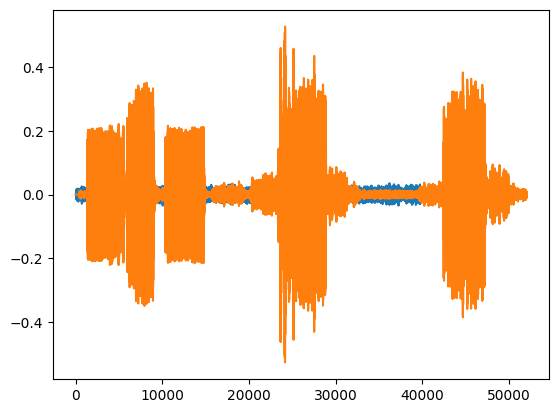

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [7]:
POS = os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Parsed_Not_Capuchinbird_Clips')

In [8]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [10]:
lengths = []
for file in os.listdir(os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [11]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [12]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [13]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [14]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [18]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [19]:
spectrogram, label = preprocess(filepath, label)

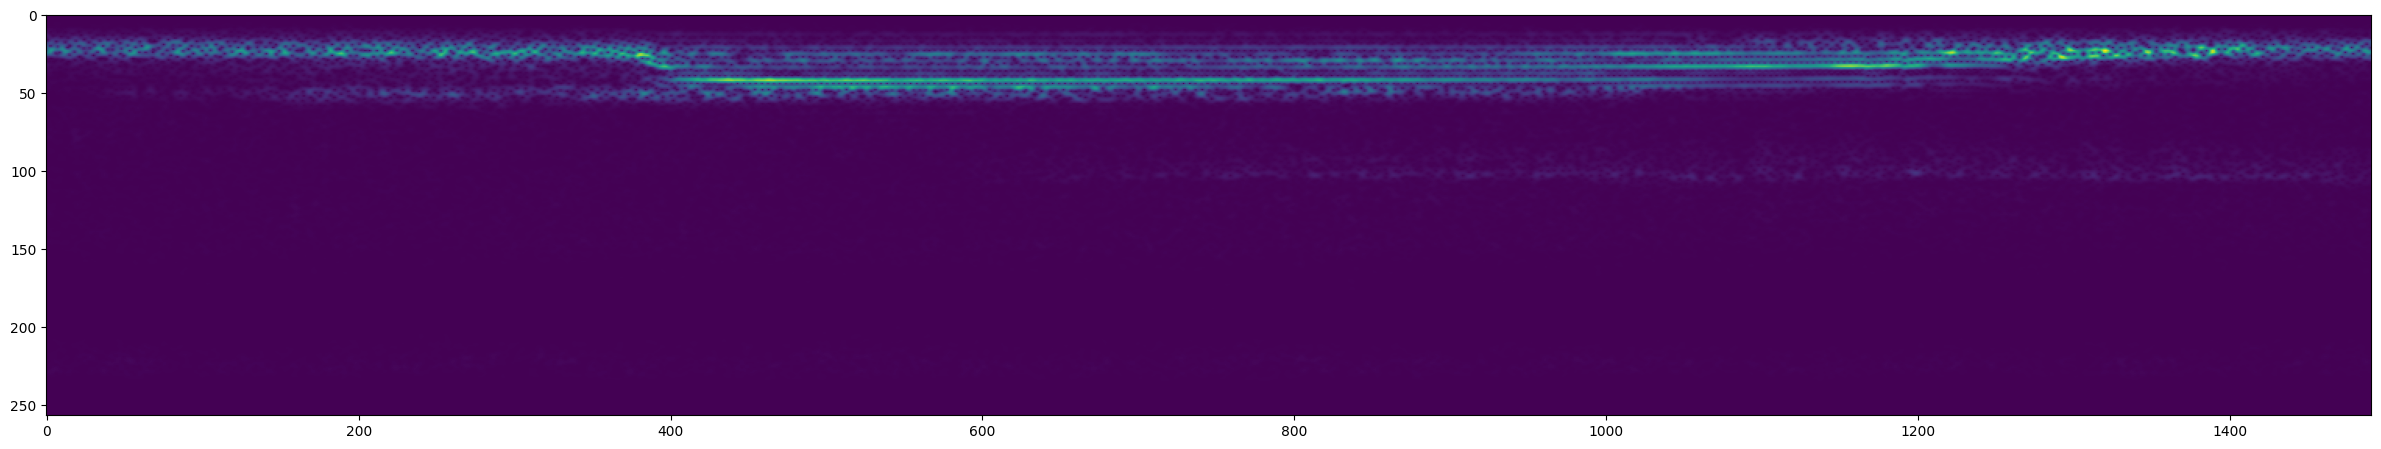

In [20]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [21]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [22]:
len(data)

51

In [23]:
train = data.take(36)
test = data.skip(36).take(15)

In [24]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
samples.shape

(16, 1491, 257, 1)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [27]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [29]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 14s 57ms/step - loss: 1.9377 - recall: 0.8851 - precision: 0.8188 - val_loss: 0.1068 - val_recall: 1.0000 - val_precision: 0.8413
Epoch 2/4
36/36 [==============================] - 2s 44ms/step - loss: 0.0370 - recall: 0.9536 - precision: 0.9863 - val_loss: 0.0072 - val_recall: 0.9825 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 2s 44ms/step - loss: 0.0216 - recall: 0.9935 - precision: 0.9935 - val_loss: 0.0045 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 2s 44ms/step - loss: 0.0198 - recall: 0.9868 - precision: 0.9675 - val_loss: 0.0058 - val_recall: 1.0000 - val_precision: 1.0000


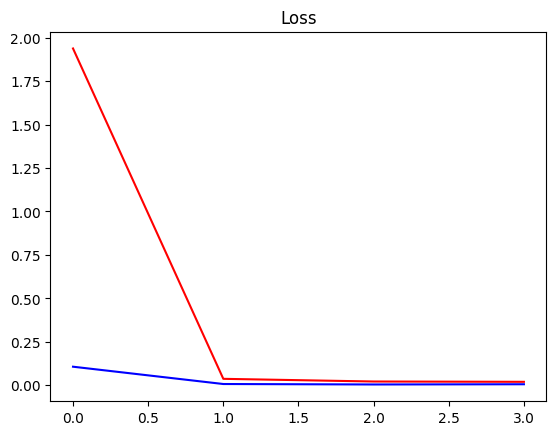

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

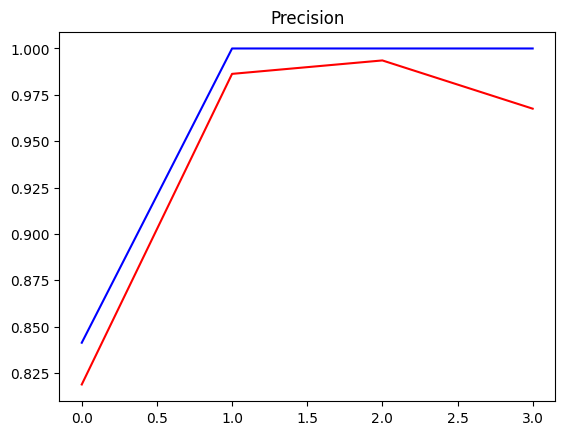

In [32]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

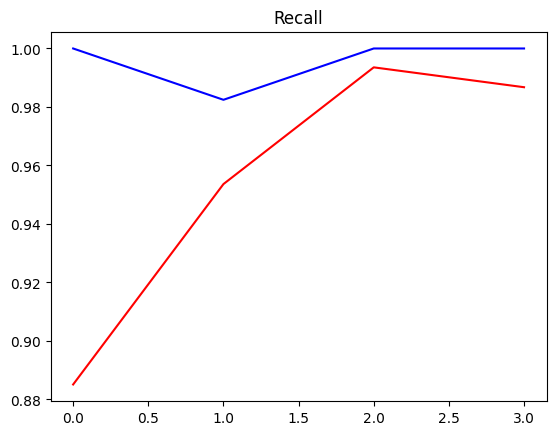

In [33]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [34]:
X_test, y_test = test.as_numpy_iterator().next()

In [35]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 106ms/step


In [36]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [37]:
yhat

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [38]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [40]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

In [41]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [42]:
mp3 = os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Forest Recordings/recording_00.mp3')

In [43]:
wav = load_mp3_16k_mono(mp3)

In [44]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [45]:
samples, index = audio_slices.as_numpy_iterator().next()

In [46]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [47]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [48]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

3/3 [==============================] - 3s 530ms/step


In [49]:
from itertools import groupby

In [50]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [51]:
calls

5

In [52]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Forest Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/Replicate #2/AudioDetection/Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 0s 367ms/step


In [53]:
results

{'recording_04.mp3': array([[8.5867114e-06],
        [1.8032739e-05],
        [1.0380926e-04],
        [9.9949777e-01],
        [3.0478027e-01],
        [3.8337690e-05],
        [6.2699255e-05],
        [3.7634687e-05],
        [1.0044852e-04],
        [4.9945142e-05],
        [6.7767083e-05],
        [9.3465445e-05],
        [6.2694753e-06],
        [3.1144507e-05],
        [3.9212835e-05],
        [1.7693912e-05],
        [5.4590707e-08],
        [7.5428099e-05],
        [9.5116768e-05],
        [1.3326388e-04],
        [2.0420885e-05],
        [9.2903956e-06],
        [6.6751905e-05],
        [1.7855864e-04],
        [1.4992130e-04],
        [5.7385569e-05],
        [3.2756325e-05],
        [4.4756041e-05],
        [1.1296886e-04],
        [2.9929175e-05],
        [6.6054788e-05],
        [6.5197310e-05],
        [4.8284688e-05],
        [9.5809148e-05],
        [1.0333785e-04],
        [4.5498919e-06],
        [8.9993937e-06],
        [4.4771487e-06],
        [1.0000000e+00],
     

In [54]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_04.mp3': [0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0],
 'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_06.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  

In [55]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_04.mp3': 4,
 'recording_00.mp3': 5,
 'recording_06.mp3': 5,
 'recording_02.mp3': 0,
 'recording_05.mp3': 0,
 'recording_03.mp3': 0,
 'recording_01.mp3': 0,
 'recording_11.mp3': 2,
 'recording_12.mp3': 0,
 'recording_10.mp3': 5,
 'recording_13.mp3': 0,
 'recording_08.mp3': 25,
 'recording_07.mp3': 2,
 'recording_09.mp3': 0,
 'recording_14.mp3': 0,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_19.mp3': 0,
 'recording_15.mp3': 2,
 'recording_18.mp3': 4,
 'recording_26.mp3': 2,
 'recording_25.mp3': 0,
 'recording_27.mp3': 0,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_21.mp3': 1,
 'recording_20.mp3': 0,
 'recording_24.mp3': 0,
 'recording_28.mp3': 4,
 'recording_32.mp3': 2,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_33.mp3': 0,
 'recording_31.mp3': 1,
 'recording_35.mp3': 0,
 'recording_34.mp3': 4,
 'recording_42.mp3': 0,
 'recording_39.mp3': 2,
 'recording_38.mp3': 1,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_43.

In [56]:
import csv

In [57]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])